In [28]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import time
import math
import seaborn as sns
import numpy as np
np.random.seed(0)
from matplotlib import pyplot as plt
torch.manual_seed(0)

In [29]:
# definining general terms

# generate colocation points
'''
import random
random.seed(1)
lower_bound = 0
upper_bound = 8
N_col = 100
t_col = [random.uniform(lower_bound,upper_bound) for _ in range(N_col)]
t_col = torch.tensor(t_col).reshape(1, -1).T
'''

N_col = 11
lower_bound = 0
upper_bound = 10*math.pi
t_col_unif = torch.linspace(lower_bound, upper_bound, steps=N_col).reshape(1,-1).T

import random
random.seed(0)
t_col_random = [random.uniform(lower_bound,upper_bound) for _ in range(N_col)]
t_col_random = torch.tensor(t_col_random).reshape(1, -1).T

# time for initial condition
t_init = [0.0]
t_init = torch.tensor(t_init).reshape(1, -1).T

In [30]:
class NN(nn.Module):
    def __init__(self,):
        super(NN, self).__init__()
        #Linear layers
        self.mod = nn.Sequential(
            nn.Linear(1, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, inpu):
        out = self.mod(inpu)
        return out

In [31]:
class Model:
    def __init__(self, t_col, t_init, alpha):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        #self.model = NN().to(device)
        self.model = NN().to(device)
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        
        #Max iteration
        self.max_iter = 4000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        self.optimizer = optim.Adam(self.model.parameters())
        
        #Initialization for training
        
        # frequency
        self.alpha = alpha
        
        # tensor of collocation points
        #Create grid for solution
        self.grid = t_col.to(device)  # no need to create grid for 1D problem
        self.grid.requires_grad = True
        
        # tensor of initial condition points
        # Points for boundary conditions (both are same) 
        self.train_points = t_init.to(device) # Training points as a grid
        self.train_points.requires_grad = True
        
        # function values at initial conditions
        self.u_initial = 0*torch.ones(len(self.train_points)).reshape(1,-1).T.to(device)
        self.ut_initial = 1*torch.ones(len(self.train_points)).reshape(1,-1).T.to(device)

        self.iter = 1
    
    def loss(self):
        # self.lbfgs.zero_grad()
        self.optimizer.zero_grad()
        
        y = self.model(self.train_points) 
        dy_dt = torch.autograd.grad(inputs=self.train_points, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        
        loss = self.criterion(y, self.u_initial) #Compute first part of loss
        loss += self.criterion(dy_dt, self.ut_initial) #Compute second part of loss
        
        u = self.model(self.grid)
        #Compute gradients of grid with respect to t
        du_dt = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt2 = torch.autograd.grad(inputs=self.grid, outputs=du_dt, grad_outputs=torch.ones_like(du_dt), retain_graph=True, create_graph=True)[0]
        
        #third part of loss, using f(t,x) as in paper
        loss += self.criterion(du_dt2 + 2*du_dt + u, 2*torch.cos(self.alpha*self.grid))  
        
        
        loss.backward()
        #Print loss every 100 iteration
        '''
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        '''
        self.iter = self.iter + 1

        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
            #self.lbfgs.step(self.loss)


<bound method Figure.show of <Figure size 1500x500 with 2 Axes>>

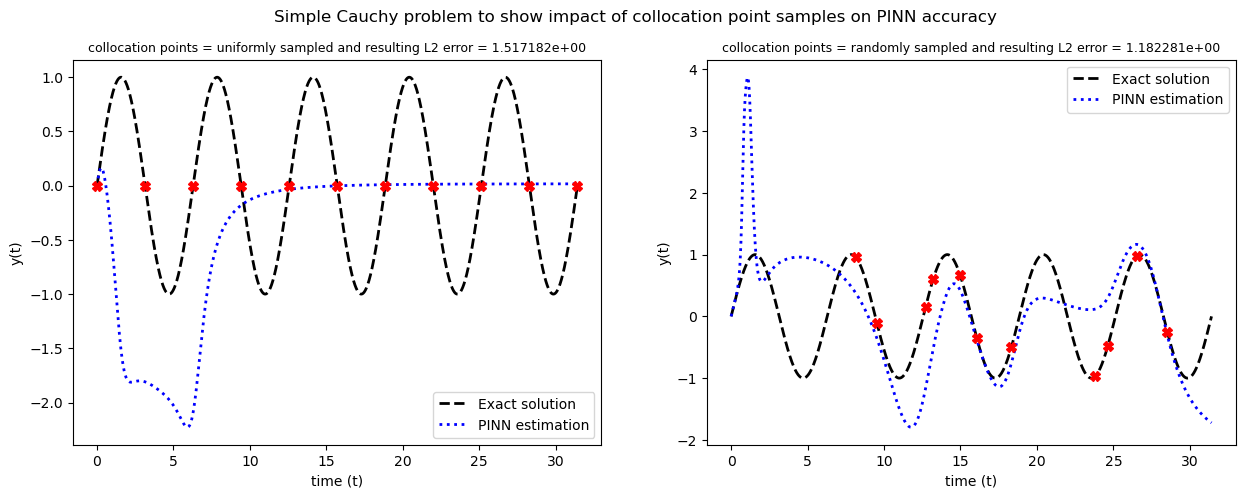

In [32]:
alpha = 1

def result_funct(alpha, t):
    return torch.sin(alpha*t)

N_fine = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
t_fine = torch.linspace(lower_bound, upper_bound, steps=N_fine).reshape(1,-1).T.to(device)


y_exact = result_funct(alpha, t_fine)

t_col_lst = [t_col_unif, t_col_random]
col_type = ['uniformly sampled', 'randomly sampled']
error_lst = []

fig, ax = plt.subplots(1,2, figsize=(15, 5))
plt_idx = 0
for t_col in t_col_lst:
    torch.manual_seed(0)
    model = Model(t_col, t_init, alpha)
    model.train()

    mod = model.model
    mod.eval()
    with torch.no_grad():
        y_pred = mod(t_fine).cpu()

    mse = nn.MSELoss()
    error_MSE = mse(y_pred, y_exact)
    
    error_L2 = np.linalg.norm(y_exact - y_pred,2)/np.linalg.norm(y_exact,2) 
    
    error_lst.append(error_L2)


    ax[plt_idx].plot(t_fine, y_exact, color='black',linestyle='--', linewidth=2, label='Exact solution')
    ax[plt_idx].plot(t_fine, y_pred, color='blue', linestyle=':', linewidth=2, label='PINN estimation')
    ax[plt_idx].plot(t_col.cpu().detach().numpy(), result_funct(alpha,t_col).cpu().detach().numpy(), 'X',ms = 7,mec = 'r',mfc = 'r')
    ax[plt_idx].legend()
    ax[plt_idx].set(xlabel="time (t)", ylabel="y(t)")
    ax[plt_idx].set_title('collocation points = %s and resulting L2 error = %e'%(col_type[plt_idx],error_L2),fontsize=9)
    plt_idx+=1

    
plt.suptitle("Simple Cauchy problem to show impact of collocation point samples on PINN accuracy")
fig.show



The graph above uses 7 collocation points.

The uniform sampling is done such as to pick 0, pi, 2pi, ... , 6pi.

Overall the sampling method doesn't really impact the result. We've tried varying the number of collocation point (10,20,40,50,100...) and we can't firmly say that one method works better than the other - at least not for this example